# Parallel Tempering for Bayesian Inference and Reliability analyses

The general framework: one wants to sample from a distribution of the form

$$ p_{1}(x) = \frac{q_{1}(x) p_{0}(x)}{Z_{1}} $$

where $q_{1}(x)$ and $p_{0}(x)$ can be evaluated; and potentially estimate the constant $Z_{1}=\int{q_{1}(x) p_{0}(x)dx}$. Parallel tempering introduces a sequence of intermediate distributions:

$$ p_{\beta}(x) \propto q(x, \beta) p_{0}(x) $$ 

for values of $\beta$ in [0, 1] (note: $\beta$ is $1/T$ where $T$ is often referred as the temperature). Setting $\beta=1$ equates sampling from the target, while $\beta \rightarrow 0$ samples from the reference distribution $p_{0}$. Periodically during the run, the different temperatures swap members of their ensemble in a way that preserves detailed balance. The chains closer to the reference chain (hot chains) can sample from regions that have low probability under the target and thus allow a better exploration of the parameter space, while the cold chains can better explore the regions of high likelihood.

The normalizing constant $Z_{1}$ is estimated via thermodynamic integration:

$$ \ln{Z_{\beta=1}} = \ln{Z_{\beta=0}} + \int_{0}^{1} E_{p_{\beta}} \left[ \frac{\partial \ln{q_{\beta}(x)}}{\partial \beta} \right] d\beta = \ln{Z_{\beta=0}} + \int_{0}^{1} E_{p_{\beta}} \left[ U_{\beta}(x) \right] d\beta$$

where $\ln{Z_{\beta=0}}=\int{q_{\beta=0}(x) p_{0}(x)dx}$ can be determined by simple MC sampling since $q_{\beta=0}(x)$ is close to the reference distribution $p_{0}$. The function $U_{\beta}(x)=\frac{\partial \ln{q_{\beta}(x)}}{\partial \beta}$ is called the potential, and can be evaluated using posterior samples from $p_{\beta}(x)$.

In the code, the user must define:
- a function to evaluate the reference distribution $p_{0}(x)$,
- a function to evaluate the intermediate factor $q(x, \beta)$ (function that takes in two inputs: x and $\beta$),
- if evaluation of $Z_{1}$ is of interest, a function that evaluates the potential $U_{\beta}(x)$, from evaluations of $\ln{(x, \beta)}$ which are saved during the MCMC run for the various chains (different $\beta$ values).

## Bayesian inference

In the Bayesian setting, $p_{0}$ is the prior and, given a likelihood $L(data; x)$:

$$ q_{T}(x) = L(data; x) ^{\beta} $$

Then for the model evidence:

$$ U_{\beta}(x) = \ln{L(data; x)} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from UQpy.RunModel import RunModel
from UQpy.Distributions import MVNormal, JointInd, Normal, Uniform
folder_uqpy_runs = '/Users/audreyolivier/Data/Trash_UQpy_runs/run'

In [2]:
from scipy.stats import multivariate_normal, norm, uniform
# bimodal posterior
mu1 = np.array([1., 1.])
mu2 = -0.8 * np.ones(2)
w1 = 0.5
# Width of 0.1 in each dimension
sigma1 = np.diag([0.02, 0.05])
sigma2 = np.diag([0.05, 0.02])

# define prior, likelihood and target (posterior)
prior_distribution = JointInd(marginals=[Uniform(loc=-2, scale=4), Uniform(loc=-2, scale=4)])

def log_likelihood(x):
    # Posterior is a mixture of two gaussians
    return np.logaddexp(np.log(w1) + multivariate_normal.logpdf(x=x, mean=mu1, cov=sigma1),
                        np.log(1.-w1) + multivariate_normal.logpdf(x=x, mean=mu2, cov=sigma2))
    
def log_target(x):
    return log_likelihood(x) + prior_distribution.log_pdf(x)

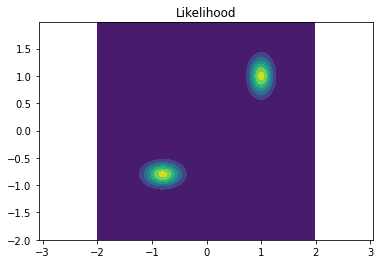

Evidence computed analytically = 0.062499877742670795


In [3]:
# estimate evidence
def estimate_evidence_from_prior_samples(size):
    samples = -2. + 4 * np.random.uniform(size=size * 2).reshape((size, 2))
    return np.mean(np.exp(log_likelihood(samples)))

def func_integration(x1, x2):
    x = np.array([x1, x2]).reshape((1, 2))
    return np.exp(log_likelihood(x)) * (1. / 4) ** 2

def estimate_evidence_from_quadrature():
    from scipy.integrate import dblquad
    ev = dblquad(func=func_integration, a=-2, b=2, gfun=lambda x: -2, hfun=lambda x: 2)
    return ev

x = np.arange(-2, 2, 0.02)
y = np.arange(-2, 2, 0.02)
xx, yy = np.meshgrid(x, y)
z = np.exp(log_likelihood(np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=-1)))
h = plt.contourf(x,y,z.reshape(xx.shape))
plt.title('Likelihood')
plt.axis('equal')
plt.show()

#for nMC in [50000, 100000, 500000, 1000000]:
#    print('Evidence = {}'.format(estimate_evidence_from_prior_samples(nMC)))
print('Evidence computed analytically = {}'.format(estimate_evidence_from_quadrature()[0]))

(20000, 2)


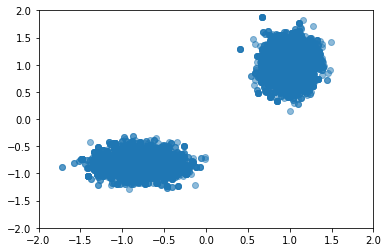

Estimated evidence by HM=0.12578579084658104


In [4]:
from UQpy.SampleMethods import Stretch, MH
seed = -2. + 4. * np.random.rand(100, 2)
mcmc0 = MH(log_pdf_target=log_target, nburn=100, jump=3, seed=seed, dimension=2, random_state=123, 
          save_log_pdf=True)
mcmc0.run(nsamples_per_chain=200)

print(mcmc0.samples.shape)
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.scatter(mcmc0.samples[:, 0], mcmc0.samples[:, 1], alpha=0.5)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
plt.show()

def estimate_evidence_from_posterior_samples(log_posterior_values, posterior_samples):
    log_like = log_likelihood(posterior_samples) #log_posterior_values - log_prior(posterior_samples)
    ev = 1. / np.mean(1. / np.exp(log_like))
    return ev
evidence = estimate_evidence_from_posterior_samples(
    log_posterior_values=mcmc0.log_pdf_values, posterior_samples=mcmc0.samples)
print('Estimated evidence by HM={}'.format(evidence))

In [5]:
def log_intermediate(x, beta):
    return beta * log_likelihood(x)# + (1. - 1. / temperature) * log_prior(x)

In [6]:
from UQpy.SampleMethods import Stretch, MH, ParallelTemperingMCMC
seed = -2. + 4. * np.random.rand(5, 2)
betas = [1. / np.sqrt(2.) ** i for i in range(20-1, -1, -1)]
print(len(betas))
print(betas)
mcmc = ParallelTemperingMCMC(log_pdf_intermediate=log_intermediate, distribution_reference=prior_distribution,
                             niter_between_sweeps=10, betas=betas, save_log_pdf=True,
                             mcmc_class=MH, nburn=100, jump=3, seed=seed, dimension=2, random_state=123)
mcmc.run(nsamples_per_chain=200)
print(mcmc.samples.shape)
print(mcmc.mcmc_samplers[-1].samples.shape)

20
[0.0013810679320049738, 0.0019531249999999974, 0.002762135864009948, 0.0039062499999999957, 0.005524271728019897, 0.007812499999999993, 0.011048543456039795, 0.015624999999999986, 0.022097086912079594, 0.03124999999999998, 0.044194173824159196, 0.06249999999999997, 0.08838834764831839, 0.12499999999999994, 0.1767766952966368, 0.24999999999999994, 0.3535533905932737, 0.4999999999999999, 0.7071067811865475, 1.0]
(1000, 2)
(1000, 2)


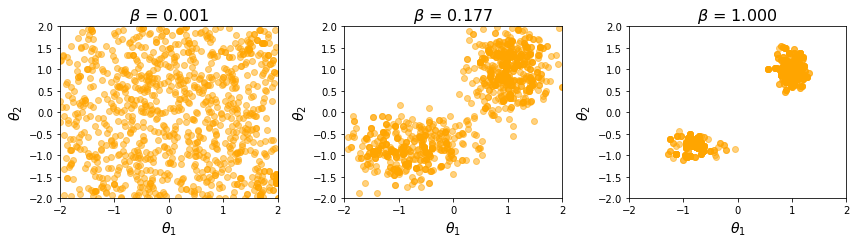

In [17]:
# the intermediate samples can be accessed via the mcmc_samplers.samples attributes or 
# directly via the intermediate_samples attribute
fig, ax = plt.subplots(ncols=3, figsize=(12, 3.5))
for j, ind in enumerate([0, -6, -1]):
    ax[j].scatter(mcmc.mcmc_samplers[ind].samples[:, 0], mcmc.mcmc_samplers[ind].samples[:, 1], alpha=0.5,
                  color='orange')
    #ax[j].scatter(mcmc.intermediate_samples[ind][:, 0], mcmc.intermediate_samples[ind][:, 1], alpha=0.5, 
    #              color='orange')
    ax[j].set_xlim([-2, 2])
    ax[j].set_ylim([-2, 2])
    ax[j].set_title(r'$\beta$ = {:.3f}'.format(mcmc.betas[ind]), fontsize=16)
    ax[j].set_xlabel(r'$\theta_{1}$', fontsize=14)
    ax[j].set_ylabel(r'$\theta_{2}$', fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
def compute_potential(x, beta, log_intermediate_values):
    """  """
    return log_intermediate_values / beta

In [10]:
ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, log_Z0=0.)
print('Estimate of evidence by thermodynamic integration = {:.4f}'.format(ev))

ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, nsamples_from_p0=5000)
print('Estimate of evidence by thermodynamic integration = {:.4f}'.format(ev))

Estimate of evidence by thermodynamic integration = 0.0590
Estimate of evidence by thermodynamic integration = 0.0565


## Reliability

In a reliability context, $p_{0}$ is the pdf of the parameters and we have:

$$ q_{\beta}(x) = I_{\beta}(x) = \frac{1}{1 + \exp{ \left( \frac{G(x)}{1/\beta-1}\right)}} $$

where $G(x)$ is the performance function, negative if the system fails, and $I_{\beta}(x)$ are smoothed versions of the indicator function. Then to compute the probability of failure, the potential can be computed as:

$$ U_{\beta}(x) = \frac{- \frac{G(x)}{(1-\beta)^2}}{1 + \exp{ \left( -\frac{G(x)}{1/\beta-1} \right) }} = - \frac{1 - I_{\beta}(x)}{\beta (1 - \beta)} \ln{ \left[ \frac{1 - I_{\beta}(x)}{I_{\beta}(x)} \right] }$$

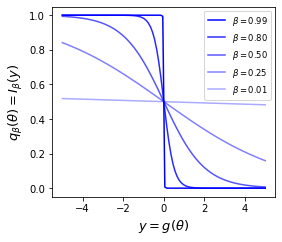

In [18]:
from scipy.stats import norm
def indic_sigmoid(y, beta):
    return 1. / (1. + np.exp(y / (1./beta-1.)))

fig, ax = plt.subplots(figsize=(4, 3.5))
ys = np.linspace(-5, 5, 100)
for i, s in enumerate(1./np.array([1.01, 1.25, 2., 4., 70.])):
    ax.plot(ys, indic_sigmoid(y=ys, beta=s), label=r'$\beta={:.2f}$'.format(s), color='blue', alpha=1. - i/6)
ax.set_xlabel(r'$y=g(\theta)$', fontsize=13)
ax.set_ylabel(r'$q_{\beta}(\theta)=I_{\beta}(y)$', fontsize=13)
#ax.set_title(r'Smooth versions of the indicator function', fontsize=14)
ax.legend(fontsize=8.5)
plt.show()

In [19]:
1/1.01

0.9900990099009901

In [20]:
beta = 2 # Specified Reliability Index
rho = 0.7 # Specified Correlation
dim = 2  # Dimension


# Define the correlation matrix
C = np.ones((dim, dim)) * rho
np.fill_diagonal(C, 1)
print(C)

# Print information related to the true probability of failure
e, v = np.linalg.eig(np.asarray(C))
beff = np.sqrt(np.max(e)) * beta
print(beff)
from scipy.stats import norm
pf_true = norm.cdf(-beta)
print('True pf={}'.format(pf_true))

[[1.  0.7]
 [0.7 1. ]]
2.6076809620810595
True pf=0.022750131948179195


In [21]:
def estimate_Pf_0(samples, model_values):
    mask = model_values <= 0
    return np.sum(mask)/len(mask)

Prob. failure (MC) = 0.02365


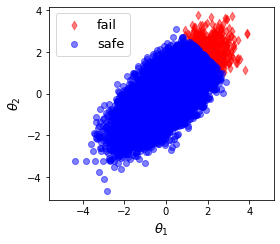

In [22]:
# Sample from the prior
model = RunModel(model_script='reliability_funcs.py', model_object_name="correlated_gaussian", ntasks=1, 
                 b_eff=beff, d=dim, model_dir=folder_uqpy_runs)
samples = MVNormal(mean=np.zeros((2,)), cov=np.array([[1, 0.7], [0.7, 1]])).rvs(nsamples=20000)
model.run(samples=samples, append_samples=False)
model_values = np.array(model.qoi_list)

print('Prob. failure (MC) = {}'.format(estimate_Pf_0(samples, model_values)))

fig, ax = plt.subplots(figsize=(4, 3.5))
mask = model_values <= 0
ax.scatter(samples[mask, 0], samples[mask, 1], color='red', label='fail', alpha=0.5, marker='d')
ax.scatter(samples[~mask, 0], samples[~mask, 1], color='blue', label='safe', alpha=0.5)
plt.axis('equal')
#plt.title('Failure domain for reliability problem', fontsize=14)
plt.xlabel(r'$\theta_{1}$', fontsize=13)
plt.ylabel(r'$\theta_{2}$', fontsize=13)
ax.legend(fontsize=13)
fig.tight_layout()
plt.show()

In [27]:
distribution_reference = MVNormal(mean=np.zeros((2,)), cov=np.array([[1, 0.7], [0.7, 1]]))

def log_factor_temp(x, beta):
    model.run(samples=x, append_samples=False)
    G_values = np.array(model.qoi_list)
    return np.log(indic_sigmoid(G_values, beta))

12
[0.01428571 0.04       0.1        0.2        0.33333333 0.5
 0.66666667 0.83333333 0.90909091 0.95238095 0.98039216 0.99009901]


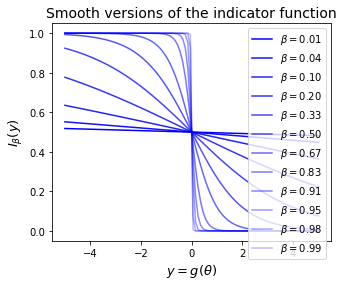

[0.8366600265340756, 0.5, 0.31622776601683794, 0.223606797749979, 0.17320508075688776, 0.1414213562373095, 0.12247448713915891, 0.10954451150103323, 0.10488088481701516, 0.10246950765959599, 0.10099504938362079, 0.1004987562112089]


In [28]:
betas = (1. / np.array([1.01, 1.02, 1.05, 1.1, 1.2, 1.5, 2., 3., 5., 10., 25., 70.]))[::-1]
#temperatures = [np.sqrt(2.) ** i for i in range(10)]

print(len(betas))
print(betas)

fig, ax = plt.subplots(figsize=(5, 4))
ys = np.linspace(-5, 5, 100)
for i, s in enumerate(betas):
    ax.plot(ys, indic_sigmoid(y=ys, beta=s), label=r'$\beta={:.2f}$'.format(s), color='blue', alpha=1. - i/15)
ax.set_xlabel(r'$y=g(\theta)$', fontsize=13)
ax.set_ylabel(r'$I_{\beta}(y)$', fontsize=13)
ax.set_title(r'Smooth versions of the indicator function', fontsize=14)
ax.legend()
plt.show()

scales = [0.1 / np.sqrt(beta) for beta in betas]
print(scales)
kwargs_mcmc = {'proposal_is_symmetric': [True, ] * len(betas),
                'proposal': [JointInd([Normal(scale=scale)] * 2) for scale in scales]}

In [29]:
from UQpy.SampleMethods import MH, ParallelTemperingMCMC
seed = -2. + 4. * np.random.rand(5, 2)

print(betas)
mcmc = ParallelTemperingMCMC(log_pdf_intermediate=log_factor_temp, distribution_reference=distribution_reference,
                             niter_between_sweeps=10, betas=list(betas), save_log_pdf=True,
                             mcmc_class=MH, nburn=5000, jump=5, seed=seed, dimension=2,
                             **kwargs_mcmc)
mcmc.run(nsamples_per_chain=250)
print(mcmc.samples.shape)
print(mcmc.mcmc_samplers[0].samples.shape)

[0.01428571 0.04       0.1        0.2        0.33333333 0.5
 0.66666667 0.83333333 0.90909091 0.95238095 0.98039216 0.99009901]
(1250, 2)
(1250, 2)


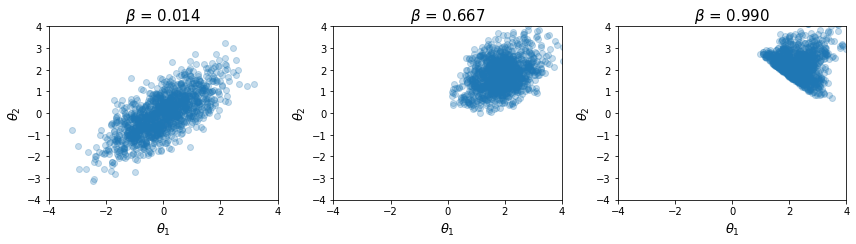

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3.5))
for j, ind in enumerate([0, 6, -1]):
    ax[j].scatter(mcmc.mcmc_samplers[ind].samples[:, 0], mcmc.mcmc_samplers[ind].samples[:, 1], alpha=0.25)
    ax[j].set_xlim([-4, 4])
    ax[j].set_ylim([-4, 4])
    ax[j].set_title(r'$\beta$ = {:.3f}'.format(mcmc.betas[ind]), fontsize=15)
    ax[j].set_xlabel(r'$\theta_{1}$', fontsize=13)
    ax[j].set_ylabel(r'$\theta_{2}$', fontsize=13)
fig.tight_layout()
plt.show()

In [32]:
print(mcmc.mcmc_samplers[0].log_pdf_values.shape, mcmc.mcmc_samplers[-1].log_pdf_values.shape)
print(np.mean(mcmc.mcmc_samplers[0].log_pdf_values), np.mean(mcmc.mcmc_samplers[-1].log_pdf_values))

(1250,) (1250,)
-3.197051838941638 -5.04100127846712


In [33]:
def compute_potential(x, beta, log_intermediate_values):
    indic_beta = np.exp(log_intermediate_values)
    indic_beta = np.where(indic_beta > 1. - 1e-16, 1. - 1e-16, indic_beta)
    indic_beta = np.where(indic_beta < 1e-16, 1e-16, indic_beta)
    tmp_log = np.log((1. - indic_beta) / indic_beta)
    return - (1. - indic_beta) / (beta * (1. - beta)) * tmp_log

In [34]:
#ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, nsamples_from_p0=200000)
#print('Estimate of evidence by thermodynamic integration = {}'.format(ev))

ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, log_Z0=np.log(0.5))
print('Estimate of evidence by thermodynamic integration = {}'.format(ev))

Estimate of evidence by thermodynamic integration = 0.01202230861057391


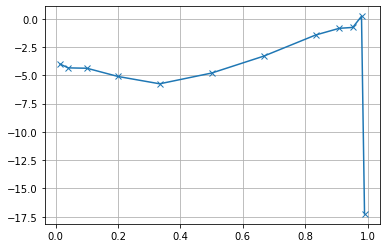

In [36]:
plt.plot(mcmc.thermodynamic_integration_results['betas'],
         mcmc.thermodynamic_integration_results['expect_potentials'], marker='x')
plt.grid(True)

Look at the evolution of the probability of failure

In [37]:
seed = -2. + 4. * np.random.rand(5, 2)
mcmc = ParallelTemperingMCMC(log_pdf_intermediate=log_factor_temp, distribution_reference=distribution_reference,
                                 niter_between_sweeps=10, betas=list(betas), save_log_pdf=True,
                                 mcmc_class=MH, nburn=5000, jump=2, seed=seed, dimension=2,
                                 **kwargs_mcmc)

list_ev_0, list_ev_1 = [], []
nsamples_per_chain = 0
for i in range(50):
    nsamples_per_chain += 50
    mcmc.run(nsamples_per_chain=nsamples_per_chain)
    ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, log_Z0=np.log(0.5))
    #print(np.exp(log_ev))
    list_ev_0.append(ev)
    ev = mcmc.evaluate_normalization_constant(compute_potential=compute_potential, nsamples_from_p0=100000)
    list_ev_1.append(ev)

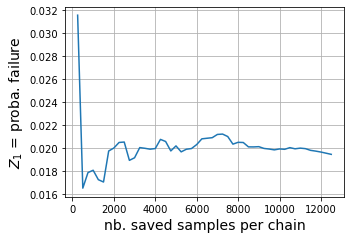

In [38]:
fig, ax = plt.subplots(figsize=(5, 3.5))
list_samples = [5 * i * 50 for i in range(1, 51)]
ax.plot(list_samples, list_ev_0)
ax.grid(True)
ax.set_ylabel(r'$Z_{1}$ = proba. failure', fontsize=14)
ax.set_xlabel(r'nb. saved samples per chain', fontsize=14)
plt.show()

In [39]:
[np.sqrt(2.) ** i for i in range(10)]

[1.0,
 1.4142135623730951,
 2.0000000000000004,
 2.8284271247461907,
 4.000000000000001,
 5.656854249492382,
 8.000000000000004,
 11.313708498984766,
 16.000000000000007,
 22.627416997969533]